In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [2]:

# Load dataset
df=pd.read_csv(".\data\parkinsons - in.csv")
df.drop(columns=['name'], inplace=True)

In [3]:
# Apply Winsorization only to numerical columns (excluding target 'status')
numeric_cols = df.drop(columns=['status']).columns
for col in numeric_cols:
    df[col] = winsorize(df[col], limits=[0.05, 0.05])

In [4]:
# Define features and target
X = df.drop(columns=['status'])
y = df['status']


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify=y)

In [6]:
# Remove low-variance features
var_thresh = VarianceThreshold(threshold=0.01)
X_train = var_thresh.fit_transform(X_train)
X_test = var_thresh.transform(X_test)

In [7]:
# Feature selection using Mutual Information
selector = SelectKBest(mutual_info_classif, k=10)  # Selecting top 10 best features
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)


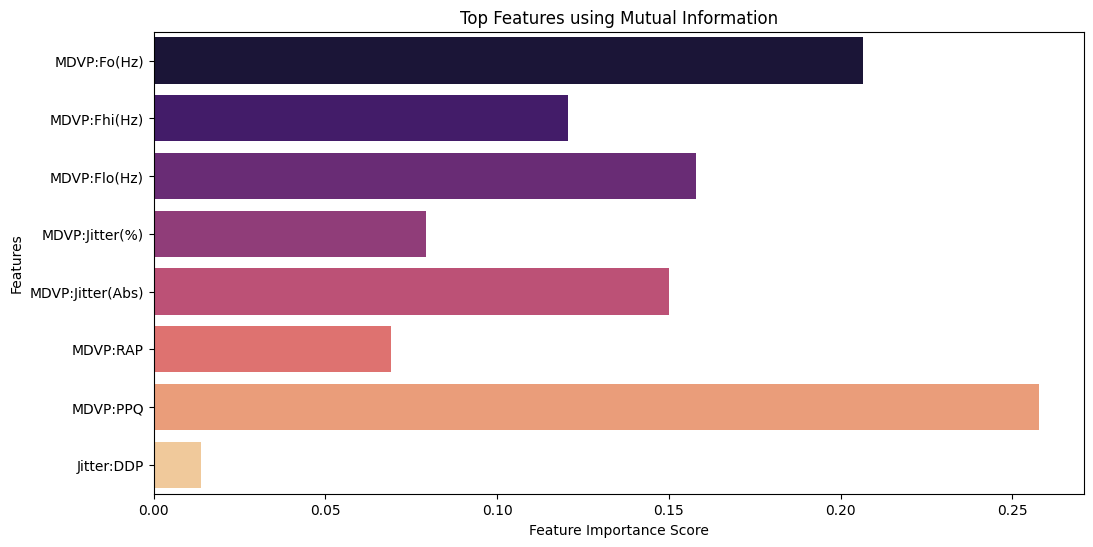

In [9]:

# Visualizing selected feature importance
selected_indices = selector.get_support(indices=True)
feature_scores = selector.scores_[selected_indices]
feature_names = X.columns[selected_indices]
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_scores, y=feature_names, palette="magma")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top Features using Mutual Information")
plt.show()

In [10]:
# Handle imbalance with SMOTE
sm = SMOTE(k_neighbors=5, random_state=1234)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [11]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=1234),
    "Decision Tree": DecisionTreeClassifier(random_state=1234),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=1234),
    "Naïve Bayes": GaussianNB(),
}

In [15]:
 #, Evaluate, and Cross-Validate models
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Model Performance:")
    print(classification_report(y_test, y_pred))
    print(f"Mean Cross-Validation Accuracy: {scores.mean():.4f}")
    if hasattr(model, "predict_proba"):
        print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.50      0.87      0.63        15
           1       0.94      0.70      0.81        44

    accuracy                           0.75        59
   macro avg       0.72      0.79      0.72        59
weighted avg       0.83      0.75      0.76        59

Mean Cross-Validation Accuracy: 0.8401
ROC-AUC Score: 0.8575757575757577

K-Nearest Neighbors Model Performance:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.93      0.91      0.92        44

    accuracy                           0.88        59
   macro avg       0.84      0.85      0.85        59
weighted avg       0.88      0.88      0.88        59

Mean Cross-Validation Accuracy: 0.9224
ROC-AUC Score: 0.9287878787878787

SVM Model Performance:
              precision    recall  f1-score   support

           0       0.71      0.67      0.

In [16]:
# Hyperparameter tuning for multiple models
param_grids = {
    "SVM": {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']},
    "Random Forest": {'n_estimators': [100, 200, 500], 'max_depth': [None, 10, 20], 'criterion': ['gini', 'entropy']},
    "K-Nearest Neighbors": {'n_neighbors': [3, 5, 7, 9, 11]},
    "Decision Tree": {'max_depth': [None, 10, 20], 'criterion': ['gini', 'entropy']},
    "XGBoost": {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200, 300], 'max_depth': [3, 6, 9]}
}

In [17]:

tuned_models = {}

for name, param_grid in param_grids.items():
    print(f"\nTuning {name}...")
    random_search = RandomizedSearchCV(models[name], param_distributions=param_grid, n_iter=10, cv=5, random_state=1234)
    random_search.fit(X_train, y_train)
    tuned_models[name] = random_search.best_estimator_
    y_pred_tuned = tuned_models[name].predict(X_test)
    print(f"\n{name} Tuned Performance:")
    print(classification_report(y_test, y_pred_tuned))
    if hasattr(tuned_models[name], "predict_proba"):
        print("ROC-AUC Score:", roc_auc_score(y_test, tuned_models[name].predict_proba(X_test)[:,1]))


Tuning SVM...

SVM Tuned Performance:
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.89      0.93      0.91        44

    accuracy                           0.86        59
   macro avg       0.83      0.80      0.81        59
weighted avg       0.86      0.86      0.86        59

ROC-AUC Score: 0.9181818181818182

Tuning Random Forest...

Random Forest Tuned Performance:
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.89      0.95      0.92        44

    accuracy                           0.88        59
   macro avg       0.86      0.81      0.83        59
weighted avg       0.88      0.88      0.88        59

ROC-AUC Score: 0.9636363636363636

Tuning K-Nearest Neighbors...

K-Nearest Neighbors Tuned Performance:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15


KeyError: 'XGBoost'

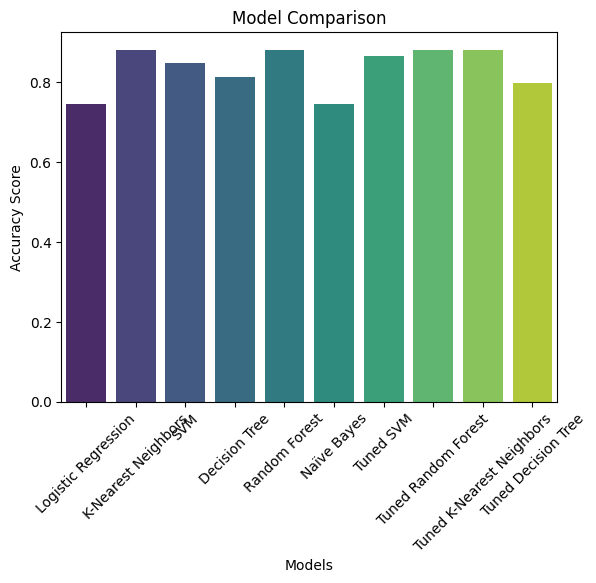

In [18]:
# Visualization
accuracies = {name: accuracy_score(y_test, model.predict(X_test)) for name, model in models.items()}
for name, model in tuned_models.items():
    accuracies[f"Tuned {name}"] = accuracy_score(y_test, model.predict(X_test))

sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.show()

In [19]:
rf = RandomForestClassifier(n_estimators=200, random_state=1234)
rf.fit(X_train, y_train)

train_acc = accuracy_score(y_train, rf.predict(X_train))
test_acc = accuracy_score(y_test, rf.predict(X_test))

print(f"Random Forest Training Accuracy: {train_acc:.4f}")
print(f"Random Forest Test Accuracy: {test_acc:.4f}")


Random Forest Training Accuracy: 1.0000
Random Forest Test Accuracy: 0.8814


In [20]:
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Cross-Validation Standard Deviation: {cv_scores.std():.4f}")


Cross-Validation Mean Accuracy: 0.9663
Cross-Validation Standard Deviation: 0.0322


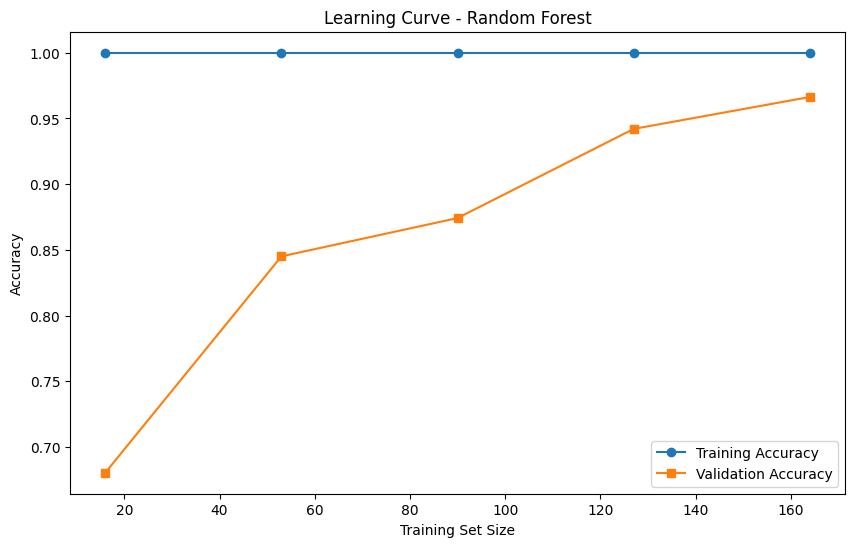

In [21]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf, X_train, y_train, cv=5, scoring="accuracy")

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", marker='o')
plt.plot(train_sizes, test_mean, label="Validation Accuracy", marker='s')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Random Forest")
plt.legend()
plt.show()
